<a href="https://colab.research.google.com/github/kimdesok/Introduction-to-TensorFlow-for-Artificial-Intelligence-Machine-Learning-and-Deep-Learning-Coursera/blob/master/C2/C2-W3-Transfer_learning_and_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [32]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

In [33]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print(path_to_zip)

/root/.keras/datasets/cats_and_dogs.zip


In [34]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [35]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


['cats', 'dogs']


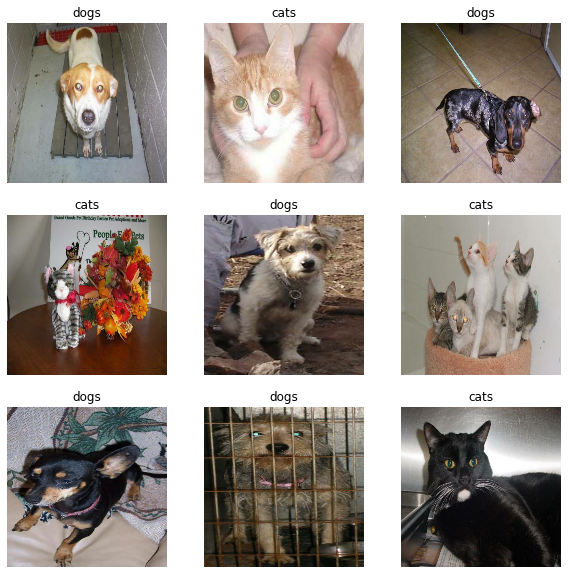

In [36]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [37]:
#assign 20 % of validation dataset to test dataset 
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [38]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [39]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [40]:
#MobileNet V2 model - pretrained on the ImageNet dataset

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [41]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Base model

In [42]:
# Create the base model from the pre-trained model MobileNet V2
# The last layer(top as in a tower) is not very useful for the feature extraction so it is excluded from the model
# by declaring include_top = False
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [43]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Feature extraction
>* Freeze the convolutional base created from the previous step and to use as a feature extractor. <br>
>* Add a classifier on top of it and train the top-level classifier.

In [44]:
#Freeze the convolutional base
base_model.trainable = False

In [45]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Add a classification head

In [46]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [47]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [48]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [49]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [51]:
len(model.trainable_variables)

2

##**Train the model**

In [52]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 7s 77ms/step - loss: 0.5833 - accuracy: 0.7450


In [53]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.58
initial accuracy: 0.75


In [54]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 12s 60ms/step - loss: 0.5514 - accuracy: 0.7015 - val_loss: 0.3803 - val_accuracy: 0.8304
Epoch 2/10
63/63 [==============================] - 4s 59ms/step - loss: 0.4095 - accuracy: 0.8015 - val_loss: 0.2895 - val_accuracy: 0.8886
Epoch 3/10
63/63 [==============================] - 4s 59ms/step - loss: 0.3357 - accuracy: 0.8495 - val_loss: 0.2404 - val_accuracy: 0.8960
Epoch 4/10
63/63 [==============================] - 4s 60ms/step - loss: 0.3007 - accuracy: 0.8700 - val_loss: 0.1947 - val_accuracy: 0.9307
Epoch 5/10
63/63 [==============================] - 4s 59ms/step - loss: 0.2681 - accuracy: 0.8875 - val_loss: 0.1734 - val_accuracy: 0.9406
Epoch 6/10
63/63 [==============================] - 4s 60ms/step - loss: 0.2565 - accuracy: 0.8885 - val_loss: 0.1544 - val_accuracy: 0.9455
Epoch 7/10
63/63 [==============================] - 4s 59ms/step - loss: 0.2341 - accuracy: 0.9000 - val_loss: 0.1344 - val_accuracy: 0.9554
Epoch 8/10
6

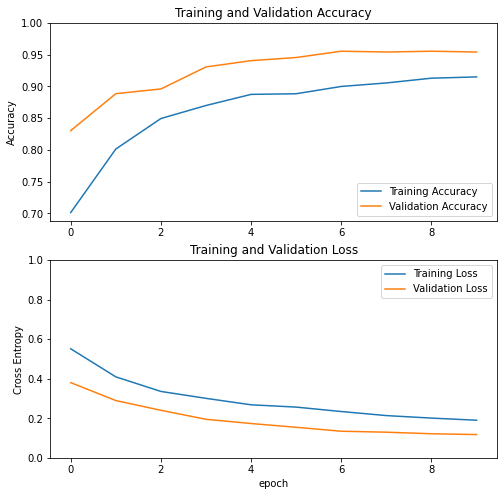

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##**Fine tuning**

>1) Un-freeze the top layers of the model: the top layer is more specific to the unique features of the train dataset whereas the bottom layer is more or less generic to the general feature of the image such as edge, steps, or corners. Thus, freeze the bottom layer and unfreeze and train the top layer in a fune tuning manner.
>2) 

In [56]:
#unfreeze the top layer of the base model
base_model.trainable = True


In [57]:
# To see layers in the base model
print('number of layers in the base model: ', len(base_model.layers))
# Fine tune from this layer onwards
fine_tune_at = 100
# Freeze other layers
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

number of layers in the base model:  154


## Compile the model


In [59]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), metrics=['accuracy'])

In [60]:
len(model.trainable_variables)

56

##Continue training the model

In [61]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 11s 79ms/step - loss: 0.1520 - accuracy: 0.9420 - val_loss: 0.0520 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 4s 67ms/step - loss: 0.1149 - accuracy: 0.9465 - val_loss: 0.0471 - val_accuracy: 0.9864
Epoch 12/20
63/63 [==============================] - 4s 67ms/step - loss: 0.1004 - accuracy: 0.9560 - val_loss: 0.0454 - val_accuracy: 0.9827
Epoch 13/20
63/63 [==============================] - 4s 67ms/step - loss: 0.0995 - accuracy: 0.9625 - val_loss: 0.0390 - val_accuracy: 0.9901
Epoch 14/20
63/63 [==============================] - 4s 67ms/step - loss: 0.0869 - accuracy: 0.9605 - val_loss: 0.0346 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 4s 68ms/step - loss: 0.0704 - accuracy: 0.9710 - val_loss: 0.0289 - val_accuracy: 0.9851
Epoch 16/20
63/63 [==============================] - 5s 74ms/step - loss: 0.0778 - accuracy: 0.9715 - val_loss: 0.0310 - val_accuracy: 0.9864
Epoch

In [62]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [63]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


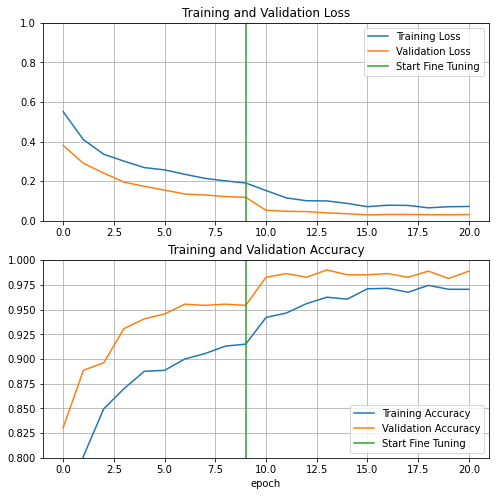

In [65]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])

plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()

plt.subplot(2, 1, 2)

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])

plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.xlabel('epoch')

plt.show()

##Evaluation and prediction

In [66]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy: ', accuracy)

6/6 [==============================] - 1s 41ms/step - loss: 0.0120 - accuracy: 1.0000
Test accuracy:  1.0


Predictions
 [0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1]
Labels:
 [0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1]


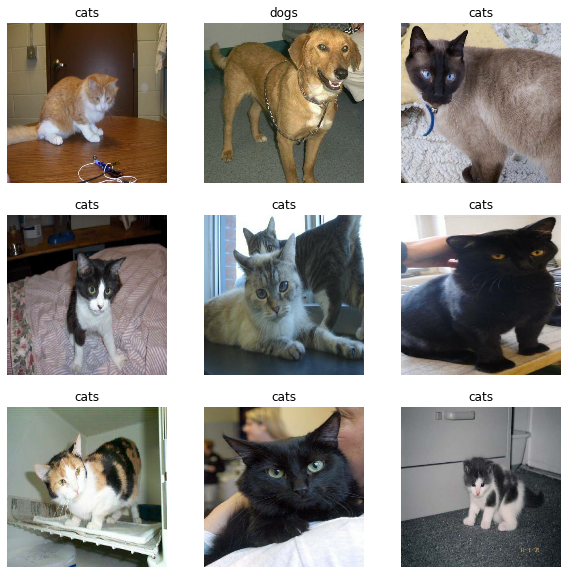

In [71]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions\n', predictions.numpy())
print("Labels:\n", label_batch)
plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].astype('uint8'))
  plt.title(class_names[predictions[i]])
  plt.axis('off')
